# Station time series plot
Dev note: Consider using dictionary for lat/lon locations, e.g.
```
BBAY_TS_loc = {
    'NOAA_46118':[48.724, -122.576]
}
```

In [1]:
import sys
sys.path.insert(1, '../scripts/')
import xarray
import yaml
import numpy as np
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

### Define path to save derived netcdf files

In [2]:
output_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data')
graphics_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics')

###  Define graphic style.  
These specifications will eventually go into a style file that is imported and these specifications will be removed from the code (so that there is just one file to modify for global changes to graphics style)

In [3]:
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

### Get run information from .yaml file and load shapefile
- The yaml file stores information on shapefile location, model output location, model run names, and graphing specifications for model runs.  Using a yaml file to store this information means that we only need to update one file if/as things change (e.g. new model runs become available)

- The shapefile has information on the Dissolved Oxygen standard (`DO_std`), which is the value to use to show toxic threshold

In [4]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['shapefile_path']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
gdf.head(1)

,node_id,Basin,uncategori,x,y,x_shp,y_shp,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
0,1249,SJF_Admiralty,None,380473.98,5365288.5,380500.860294,5.365280e+06,48.429395,-124.615801,160.628998,1,7,1.824350e+09,11357538.53,13249.778795,1.135754e+07,"POLYGON ((378570.860 5364434.875, 378213.530 5..."


### Define station locations for creating timeseries

In [5]:
station_id=[
    'NOAA Station 46118', 
    'BHAM-Bay Low DO', 
    'Birch Bay', 
    'Birch Bay (Point Whitehorn)',
    'Cherry Point', 
    'Eastsound']
station_lat=np.array([48.724, 48.767422, 48.898880, 48.895273, 48.868451, 48.684406])
station_lon=np.array([-122.57, -122.575792, -122.781905, -122.805067, -122.780400, -122.898953])

### Get nodes corresponding to station locations

In [6]:
node_id, df_index, st_x, st_y = get_nearest_node(
    ssm['shapefile_path'], station_lat, station_lon
)

# change BHAM-Bay Low DO to 6369 and add Quarter Master (13549)
node_id[1]=6369
df_index[1]=gdf.loc[gdf.node_id==6369].index.values.item()

node_id.append(13549)
station_id.append('Quarter Master')
df_index.append(gdf.loc[gdf.node_id==13549].index.values.item())

### Load, process, and save model results to derived netcdf product
In this setup, I specify deviation and baseline runs based on a tag name (e.g. 'existing')
so that I can change the runs that are being compared and pass different tag names into a function that allows for multiple applications.  For this example, I choose the `deviation` and `baseline` runs 

In [7]:
%%time
# deviation_index = ssm['run_index']['deviation']
# baseline_index = ssm['run_index']['baseline']
# # input netcdf filename
# deviation_path=pathlib.Path(ssm['output_paths'][deviation_index])/'s_hy_base000_pnnl007_nodes.nc'
# baseline_path=pathlib.Path(ssm['output_paths'][baseline_index])/'s_hy_base000_pnnl007_nodes.nc'

# specify variable to plot
graphic_var = 'DO'
# get correspoding model variable name, Var_10, for "DO"
ssm_var_name = ssm['var_name'][graphic_var] 
# create a dictionary for timeseries values
dailyDO_tmin_zmin={}
dailyDO_tmin_bottom={} 
# loop through comparison cases and get timeseries from model output
for run_type in ['deviation','baseline']:
    # input netcdf filename
    index = ssm['run_index'][run_type]
    path=pathlib.Path(
        ssm['output_paths'][index])/'s_hy_base000_pnnl007_nodes.nc'
    print(path.as_posix())
    dailyDO_tmin_zmin[run_type]={}
    # load variable into xarray and calculate daily min.
    with xarray.open_dataset(path) as ds:
        dailyDO = reshape_fvcom(
            ds[ssm_var_name][:,:].data, 
            'days'
        ) #return (365x24xnodes)
    # calculate daily minimum
    dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
    # reshape to levels
    dailyDO_tmin_rshp = reshape_fvcom(dailyDO_tmin, 'levels')
    # store time series of minimum across depth levels & save to file
    dailyDO_tmin_zmin[run_type] = calc_fvcom_stat(dailyDO_tmin_rshp, 'min', axis=2)
    xr_minDO=xarray.DataArray(dailyDO_tmin_zmin[run_type], name='DailyMinDO')
    xr_minDO.to_netcdf(output_dir/f'dailyDO_tmin_zmin_{run_type}.nc')
    
    # store time series of daily min bottom DO & save to file
    dailyDO_tmin_bottom[run_type] = dailyDO_tmin_rshp[:,:,-1]
    xr_minbotDO=xarray.DataArray(dailyDO_tmin_bottom[run_type], name='DailyMinBottomDO')
    xr_minbotDO.to_netcdf(output_dir/f'dailyDO_tmin_bottom_{run_type}.nc')
    

/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_exist_orig/hotstart/outputs/s_hy_base000_pnnl007_nodes.nc
8760 160120
365 160120
/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_ref_orig/hotstart/outputs/s_hy_base000_pnnl007_nodes.nc
8760 160120
365 160120
CPU times: user 4.16 s, sys: 24.9 s, total: 29 s
Wall time: 2min 17s


In [8]:
dailyDO_tmin_bottom[run_type].shape

(365, 16012)

In [13]:
dailyDO_tmin_bottom[run_type].shape

(365, 16012)

### Use `node_id - 1` values to index `dailyDO_tmin_bottom` and get values associated with shapefile footprint

In [17]:
dailyDO_tmin_bottom_shp=dailyDO_tmin_bottom[run_type][0,:][gdf['node_id']-1]

In [16]:
dailyDO_tmin_bottom_shp.shape

(7494,)

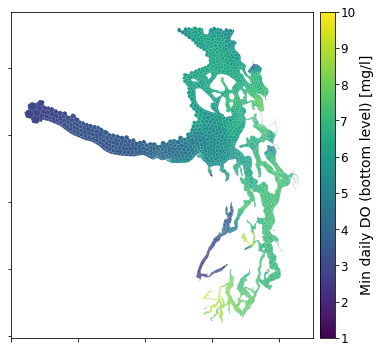

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
gdf[run_type] = dailyDO_tmin_bottom_shp 
fig, axs = plt.subplots(1,1, figsize = (8,6))
# create `cax` for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(run_type, ax=axs, cax=cax, legend=True,vmin=1, vmax=10)
cax.set_ylabel(f'Min daily DO (bottom level) [mg/l]',fontsize=14)
axs.set(yticklabels='', xticklabels='')
#axs.set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
#plt.savefig(gdir/f'minDO_01012014.jpeg',dpi=150)
plt.show()

### Load and plot derived information
- need shapefile (gdf) and derived netcdfs (create function for creating derived netcdfs)
- df_index (get_nearest_node)

### minimum across all depths 

In [22]:
# %%time
# ts={}
# idx=0
# # loop through comparison cases and get timeseries from model output
# for run_type in ['deviation','baseline']:
#     print(run_type)
#     ts[run_type]={}
#     with xarray.open_dataset(output_dir/f'dailyDO_tmin_zmin_{run_type}.nc') as ds:
#         # get timeseries at selected node ID
#         for idx,node_index in enumerate(df_index):
#             ts[run_type][station_id[idx]]=ds['DailyMinDO'][:,node_index]

deviation
baseline
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 29 ms


### bottom values

In [24]:
%%time
ts={}
idx=0
# loop through comparison cases and get timeseries from model output
for run_type in ['deviation','baseline']:
    print(run_type)
    ts[run_type]={}
    with xarray.open_dataset(output_dir/f'dailyDO_tmin_bottom_{run_type}.nc') as ds:
        # get timeseries at selected node ID
        for idx,node_index in enumerate(df_index):
            ts[run_type][station_id[idx]]=ds['DailyMinBottomDO'][:,node_index]

deviation
baseline
CPU times: user 13.5 ms, sys: 0 ns, total: 13.5 ms
Wall time: 13.7 ms


In [25]:
[*ts[run_type]]

['NOAA Station 46118',
 'BHAM-Bay Low DO',
 'Birch Bay',
 'Birch Bay (Point Whitehorn)',
 'Cherry Point',
 'Eastsound',
 'Quarter Master']

In [26]:
# create date vector
dti = pandas.date_range("2014-01-01", periods=365, freq="D")
dti

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

DO standard for node 6367 is 6
DO standard for node 6369 is 6
DO standard for node 5845 is 7
DO standard for node 5844 is 7
DO standard for node 5615 is 7
DO standard for node 5212 is 7
DO standard for node 13549 is 7


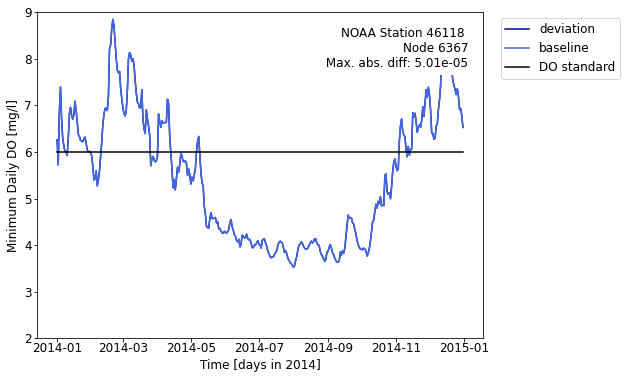

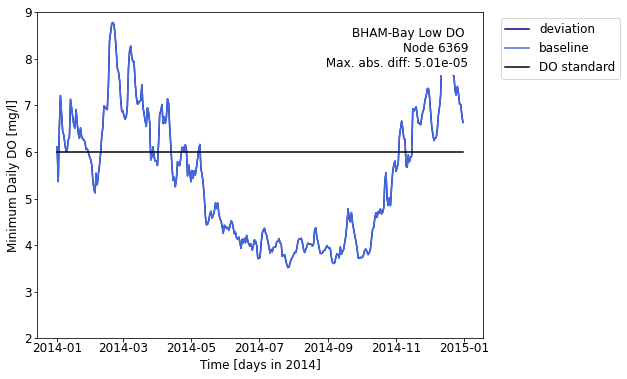

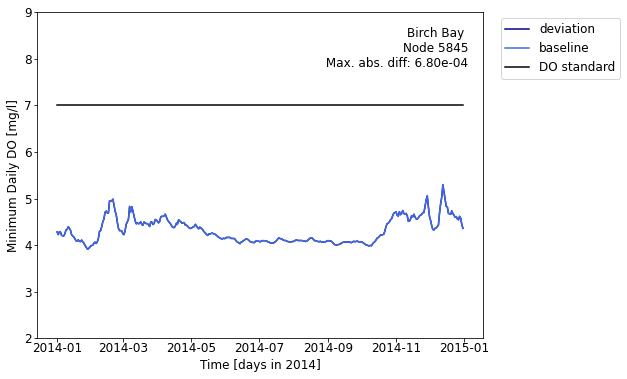

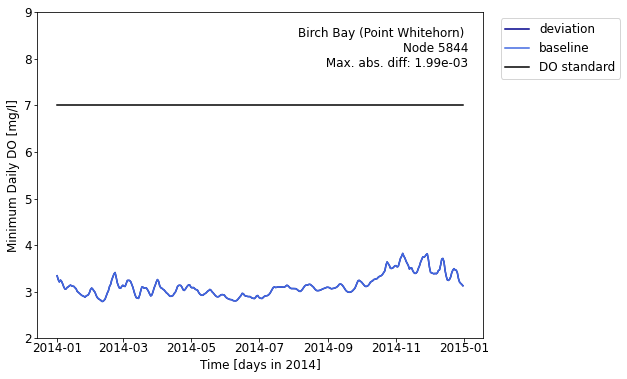

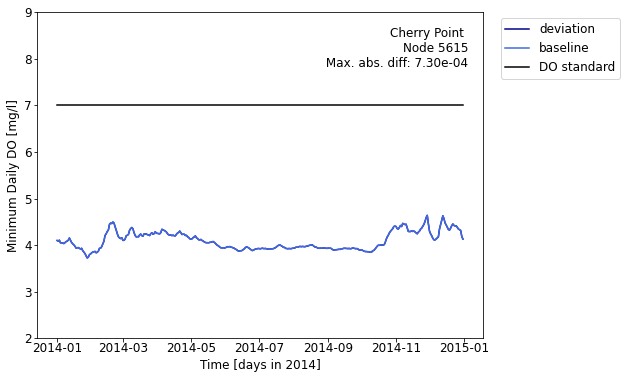

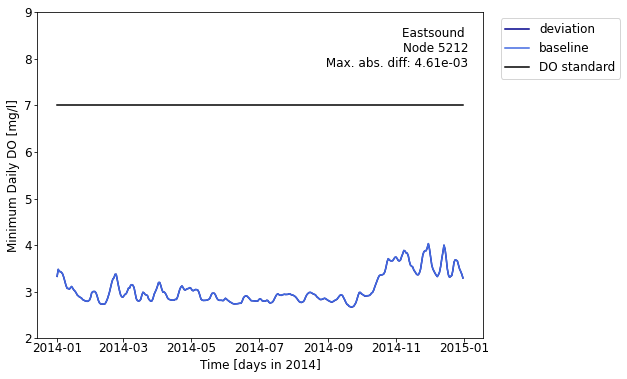

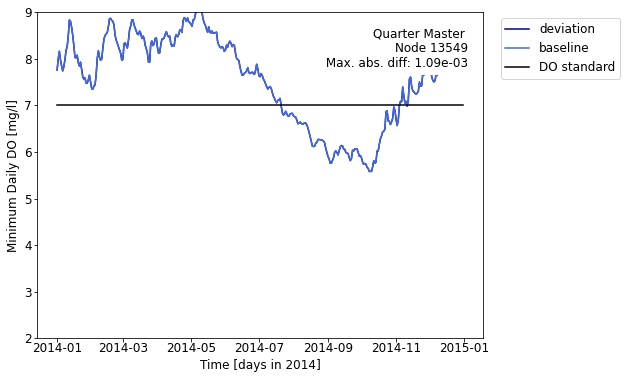

In [27]:
for idx,loc in enumerate(ts[run_type]): 
    fig, axs = plt.subplots(1,1, figsize = (8,6)) 
    print(f"DO standard for node {gdf['node_id'][df_index[idx]]} is {gdf['DO_std'][df_index[idx]]}")
    for run_type in ['deviation','baseline']:
        axs.plot(dti, 
                 ts[run_type][loc], 
                 color=ssm['line_colors'][run_type],
                 label=run_type
                )
    axs.plot(dti, 
             gdf['DO_std'][df_index[idx]]*np.ones(len(ts[run_type][loc])), 
             'k', label='DO standard'
            )    
    axs.set_ylim(2,9)
    axs.set_ylabel('Minimum Daily DO [mg/l]')
    axs.set_xlabel('Time [days in 2014]')
    leg=axs.legend(
        bbox_to_anchor=(1.32,1),
        loc='upper right'
    )
    for text in leg.get_texts():
        text.set_ha('left')
    max_diff=max(abs(ts['deviation'][loc]-ts['baseline'][loc]))
    axs.annotate(f"{loc} \nNode {gdf['node_id'][df_index[idx]]}\n Max. abs. diff: {max_diff.item():4.2e}", 
                 xy=(1, 1), xytext=(-15, -15), fontsize=12,
                 xycoords='axes fraction', 
                 textcoords='offset points',    
                 horizontalalignment='right', 
                 verticalalignment='top',
                 backgroundcolor='white')

### Plot locations

In [ ]:
node_id

In [ ]:
for idx,loc in enumerate(ts[run_type]):
    # sub-sample geodataframe with just the selected nodes
    gdf_nearest=gdf.loc[gdf.node_id==node_id[idx]]

    fig, axs = plt.subplots(1,1, figsize = (8,6))
    gdf.plot('depth', ax=axs, legend=True)
    # Plot polygon of resulting location
    gdf_nearest.plot(ax=axs,color='red',legend=True,label='Time series location')
    # Zoom into Bbay so we can actualy see overlap
    axs.set_ylim(5.37e6,5.42e6)
    axs.set_xlim(5e5,5.4e5)
    #xlabels=axs.get_xticklabels()
    axs.set_xticklabels('')
    axs.set_yticklabels('')
    axs.text(5.01e5,5.386e6,"Orcas Is.")
    axs.text(5.3e5,5.405e6,"Nooksack R.")
    axs.text(5.18e5,5.415e6,"Pt. Whitehorn")
    # axs.legend(
    #     bbox_to_anchor=(1,1),
    #     loc='upper left'
    # )
    #plt.legend()

### Extract deviation and baseline time series using the node_id(s) for desired location(s)

In [ ]:


for idx,loc in enumerate(ts[run_type]):
    fig, axs = plt.subplots(1,2, figsize = (32,8),
          gridspec_kw={
              'width_ratios': [0.3,0.7, ],
              'wspace':0.05
          })
    #~~~ Location map ~~~
    gdf.plot('depth', ax=axs[0], legend=True)
    # Plot polygon of resulting location
    # sub-sample geodataframe with just the selected nodes
    gdf_nearest=gdf.loc[gdf.node_id==node_id[idx]]
    gdf_nearest.plot(ax=axs[0],color='red',legend=True,label='Time series location')
    # Zoom into Bbay so we can actualy see overlap
    axs[0].set_ylim(5.37e6,5.42e6)
    axs[0].set_xlim(5e5,5.4e5)
    #xlabels=axs.get_xticklabels()
    axs[0].set_xticklabels('')
    axs[0].set_yticklabels('')
    axs[0].text(5.01e5,5.386e6,"Orcas Is.")
    axs[0].text(5.3e5,5.405e6,"Nooksack R.")
    axs[0].text(5.18e5,5.415e6,"Pt. Whitehorn")
    
    #~~~ Time series ~~~
    print(f"DO standard for node {gdf['node_id'][df_index[idx]]} is {gdf['DO_std'][df_index[idx]]}")
    for run_type in ['deviation','baseline']:
        axs[1].plot(dti, 
                 ts[run_type][loc], 
                 color=ssm['line_colors'][run_type],
                 label=run_type
                )
    axs[1].plot(dti, 
             gdf['DO_std'][df_index[idx]]*np.ones(len(ts[run_type][loc])), 
             'k', label='DO standard'
            )    
    axs[1].set_ylim(2,9)
    axs[1].set_ylabel('Minimum Daily DO [mg/l]')
    axs[1].set_xlabel('Time [days in 2014]')
    leg=axs[1].legend(
        bbox_to_anchor=(1.12,1),
        loc='upper right'
    )
    for text in leg.get_texts():
        text.set_ha('left')
    max_diff=max(abs(ts['deviation'][loc]-ts['baseline'][loc]))
    axs[1].annotate(f"{loc} \nNode {gdf['node_id'][df_index[idx]]}\n Max. abs. diff: {max_diff.item():4.2e}", 
                 xy=(1, 1), xytext=(-15, -15), fontsize=12,
                 xycoords='axes fraction', 
                 textcoords='offset points',    
                 horizontalalignment='right', 
                 verticalalignment='top',
                 backgroundcolor='white')
    plt.savefig(graphics_directory/
                f"minDO_comparison_node{gdf['node_id'][df_index[idx]]}")

In [ ]:

cax.set_ylabel(f'Days with DO < {threshold}[mg/l]',fontsize=14)
axs.set(yticklabels='', xticklabels='')
#axs.set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
#plt.savefig(gdir/f'SOGNB_minDO_lt{threshold}.jpeg',dpi=150)
plt.show()

## Everything below this point is just for baseline from previous developement takes

In [ ]:
# Kevin's shapefile
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/KingCounty-Rachael/kevin_shapefiles'
)/'SSMGrid2_tce.shp'
gdf_k = gpd.read_file(shapefile_path)
gdf_k = gdf_k.loc[:, ('tce','Basin','geometry')]
gdf_k=gdf_k.rename(columns={'tce':'node_id'})
# Extract SOG_Bays from Kevin's shapefile 
gdf_SOG_Nbays = gdf_k.loc[gdf_k['Basin']=='SOG_Bays']
gdf = gdf_SOG_Nbays.copy()
gdf_k.head(2)

In [ ]:
dailyDO_tmin_zmin_SOG = dailyDO_tmin_zmin[gdf['node_id']-1]

dailyDO_tmin_zmin_SOG.shape

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
gdir = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/CleanWaterAlliance/dev/minDO/')
fs_t=14
fs_a=12
cax={}
gdf['minDO'] = dailyDO_tmin_zmin_SOG   
fig, axs = plt.subplots(1,1, figsize = (8,6))
# create `cax` for the colorbar
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot('DOlt5', ax=axs, cax=cax, legend=True,vmin=1, vmax=150)
cax.set_ylabel(f'Days with DO < {threshold}[mg/l]',fontsize=14)
axs.set(yticklabels='', xticklabels='')
#axs.set_title(f'min DO (day={time_index})\nall levels', fontsize=fs_t)
#plt.savefig(gdir/f'SOGNB_minDO_lt{threshold}.jpeg',dpi=150)
plt.show()